In [1]:
!pip install mido==1.2.9
!pip install music21==6.7.1

     |████████████████████████████████| 52 kB 413 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 19.2 MB 579 kB/s eta 0:00:01
  Created wheel for music21: filename=music21-6.7.1-py3-none-any.whl size=21941692 sha256=48496a96e12eac2714b6572990d3bcb7e0f9f37daa9dbf6f794151e3cf672f5e
  Stored in directory: /root/.cache/pip/wheels/72/44/61/90e4e65262ca1b4d9f707527b540729ce3f64e00fc6b38d54c
Successfully built music21
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from mido import MidiFile
import IPython
import matplotlib.pyplot as plt
import librosa.display
import keras.layers as L
import keras.models as M
import keras
from keras.layers import SimpleRNN,LSTM,GRU
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, LSTM, Conv2DTranspose, Conv2D, LeakyReLU, GlobalMaxPooling2D, Reshape, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam

from sklearn.model_selection import train_test_split
from IPython import *
import os
import tensorflow as tf

from numpy.random import choice

from mido import Message, MidiFile, MidiTrack


In [3]:
key_notes = {
    'Cb': 59,
    'C': 60,
    'C#': 61,
    'Db': 61,
    'D': 62,
    'D#': 63,
    'Eb': 63,
    'E': 64,
    'F': 65,
    'F#': 66,
    'Gb': 66,
    'G': 67,
    'G#': 68,
    'Ab': 68,
    'A': 69,
    'A#': 70,
    'Bb': 70,
    'B': 71
}

### Just looking on the data

In [4]:
data=pd.read_csv('../input/musicnet-dataset/musicnet_metadata.csv')

In [5]:
data.head()

,id,composer,composition,movement,ensemble,source,transcriber,catalog_name,seconds
0,1727,Schubert,Piano Quintet in A major,2. Andante,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,447
1,1728,Schubert,Piano Quintet in A major,3. Scherzo: Presto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,251
2,1729,Schubert,Piano Quintet in A major,4. Andantino - Allegretto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,444
3,1730,Schubert,Piano Quintet in A major,5. Allegro giusto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,368
4,1733,Schubert,Piano Sonata in A major,2. Andantino,Solo Piano,Museopen,Segundo G. Yogore,D959,546


In [6]:
mid=MidiFile('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven/2313_qt15_1.mid',clip=True)
mid.tracks

[<midi track 'L.v.Beethoven 1mov - String Quartet No.15 in A minor Op.132\x00' 325 messages>,
 <midi track 'Violin1' 3277 messages>,
 <midi track 'Violin2' 2898 messages>,
 <midi track 'Viola' 2916 messages>,
 <midi track 'Cello' 2491 messages>,
 <midi track 'Violin1 Sub' 40 messages>]

In [7]:
for i in mid.tracks[1] :
    if 'meta' in str(i):
        print(i)

<meta message track_name name='Violin1' time=0>
<meta message key_signature key='Am' time=0>
<meta message key_signature key='Dm' time=52>
<meta message key_signature key='Am' time=128>
<meta message key_signature key='Em' time=4>
<meta message key_signature key='Am' time=384>
<meta message end_of_track time=0>


In [8]:
mid.tracks[1].name

'Violin1'

In [9]:
# Having a look at the msges of the tracks
k = 0
for i in mid.tracks[1] :
    print(i)
    k += 1
    if k > 50:
        break

<meta message track_name name='Violin1' time=0>
control_change channel=0 control=0 value=0 time=0
program_change channel=0 program=40 time=0
control_change channel=0 control=7 value=100 time=0
control_change channel=0 control=10 value=20 time=0
control_change channel=0 control=91 value=127 time=0
<meta message key_signature key='Am' time=0>
control_change channel=0 control=11 value=127 time=0
note_on channel=0 note=69 velocity=1 time=0
note_off channel=0 note=69 velocity=100 time=188
control_change channel=0 control=11 value=90 time=2860
note_on channel=0 note=63 velocity=40 time=24
control_change channel=0 control=11 value=100 time=24
control_change channel=0 control=11 value=114 time=24
control_change channel=0 control=11 value=127 time=24
note_off channel=0 note=63 velocity=100 time=692
note_on channel=0 note=64 velocity=45 time=4
note_off channel=0 note=64 velocity=100 time=764
control_change channel=0 control=11 value=70 time=4
note_on channel=0 note=72 velocity=90 time=0
control_

In [10]:
beethoven_midi_traks = {}
n=10
name = None
for m in range(n):
    mid=MidiFile('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven/'+os.listdir('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven')[m],clip=True)
    print(mid.tracks)
    for j in range(len(mid.tracks)):
        if j == 0:
            name = mid.tracks[j].name + ': '
            print(name)
        else:
            beethoven_midi_traks[name + mid.tracks[j].name] = mid.tracks[j]

[<midi track 'L.v.Beethoven 4mov - Piano Sonata No.18 in Eb Major Op.31-3\x00' 20 messages>, <midi track 'Right' 3641 messages>, <midi track 'Left' 3498 messages>, <midi track '' 7 messages>]
L.v.Beethoven 4mov - Piano Sonata No.18 in Eb Major Op.31-3 : 
[<midi track 'L.v.Beethoven 2mov - Piano Sonata No.30 in E Major Op.109\x00' 48 messages>, <midi track 'Right' 1491 messages>, <midi track 'Left' 1420 messages>]
L.v.Beethoven 2mov - Piano Sonata No.30 in E Major Op.109 : 
[<midi track 'L.v.Beethoven 1mov - Piano Sonata No.26 in Eb Major Op.81a\x00' 95 messages>, <midi track 'Right' 3621 messages>, <midi track 'Left' 3012 messages>]
L.v.Beethoven 1mov - Piano Sonata No.26 in Eb Major Op.81a : 
[<midi track 'L.v.Beethoven 1mov - Piano Sonata No.6 in F Major Op.10-2\x00' 64 messages>, <midi track 'Right' 3537 messages>, <midi track 'Left' 3598 messages>]
L.v.Beethoven 1mov - Piano Sonata No.6 in F Major Op.10-2 : 
[<midi track 'L.v.Beethoven 3mov - Piano Sonata No.12 in Ab Major Op.26\x0

In [11]:
beethoven_midi_traks

{'L.v.Beethoven 4mov - Piano Sonata No.18 in Eb Major Op.31-3\x00: Right': <midi track 'Right' 3641 messages>,
 'L.v.Beethoven 4mov - Piano Sonata No.18 in Eb Major Op.31-3\x00: Left': <midi track 'Left' 3498 messages>,
 'L.v.Beethoven 4mov - Piano Sonata No.18 in Eb Major Op.31-3\x00: ': <midi track '' 7 messages>,
 'L.v.Beethoven 2mov - Piano Sonata No.30 in E Major Op.109\x00: Right': <midi track 'Right' 1491 messages>,
 'L.v.Beethoven 2mov - Piano Sonata No.30 in E Major Op.109\x00: Left': <midi track 'Left' 1420 messages>,
 'L.v.Beethoven 1mov - Piano Sonata No.26 in Eb Major Op.81a\x00: Right': <midi track 'Right' 3621 messages>,
 'L.v.Beethoven 1mov - Piano Sonata No.26 in Eb Major Op.81a\x00: Left': <midi track 'Left' 3012 messages>,
 'L.v.Beethoven 1mov - Piano Sonata No.6 in F Major Op.10-2\x00: Right': <midi track 'Right' 3537 messages>,
 'L.v.Beethoven 1mov - Piano Sonata No.6 in F Major Op.10-2\x00: Left': <midi track 'Left' 3598 messages>,
 'L.v.Beethoven 3mov - Piano Son

In [12]:
def get_key(s):
    k = None
    if 'key' in s:
        k = s[33:35]
        if k[-1] == "m" or k[-1] == "'":
            k = k[:-1]
    return k


# function returning list of dicts with each note, it's duration and velocity 
def parse_notes(track):
    key = 'C'
    tunes = []
    new_tune = []
    note_dict = {}
    for i in track:
        
        if i.is_meta:
            new_key = get_key(str(i))
            if new_key is not None:
                key = new_key
            if len(tunes) > 0:
                tunes.append(new_tune)
                new_tune = []
                
        elif i.type == 'note_on' or i.type == 'note_off':
            if i.type == 'note_on' and i.dict()['velocity'] > 0 and i.dict()['time'] > 0:
                note_dict['time'] = i.dict()['time']
                note_dict['note'] = i.dict()['note']
                note_dict['velocity'] = i.dict()['velocity']
                note_dict['channel'] = i.dict()['channel']
            elif i.type == 'note_off' or i.type == 'note_on' and i.dict()['velocity'] == 0:
                if note_dict:
                    note_dict['pause'] = i.dict()['time']
                    note_dict['key'] = key
                    new_tune.append(note_dict)
                    note_dict = {}
    tunes.append(new_tune)
    return tunes

In [13]:
def tune_to_midi(tune, midi_name='new_tune', debug_mode=False):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    for note in tune:
        if debug_mode:
            track.append(Message('note_on', note=note, time=64))
            track.append(Message('note_off', note=note, time=128))
        else:
            track.append(Message('note_on', note=note['note'], velocity=note['velocity'], time=note['time']))
            track.append(Message('note_off', note=note['note'], time=note['pause']))

    mid.save(midi_name + '.mid')

## Preparing Data

In [14]:
tunes = []
max_key = max(key_notes.values())
for k, v in beethoven_midi_traks.items():
    if 'Right' in k:
        new_tunes = parse_notes(v)
        if len(new_tunes) > 0:
            tunes.append(pd.DataFrame(new_tunes[0]))

In [15]:
tunes[0]

,time,note,velocity,channel,pause,key
0,2496,82,80,0,188,Eb
1,4,82,80,0,380,Eb
2,4,80,80,0,188,Eb
3,4,77,80,0,380,Eb
4,4,74,80,0,188,Eb
...,...,...,...,...,...,...
1578,196,74,110,0,572,Eb
1579,4,75,110,0,572,Eb
1580,580,86,120,0,764,Eb
1581,388,87,120,0,1148,Eb


The first model I trained repeated one note constantly, so I decided to filter data samples, but turned out it does not help (

In [16]:
def various(notes):
    flag = True
    for i in range(8, len(notes)):
        flag = len(np.unique(notes[i-8:i])) > 2
        if not flag:
            break
    return flag
        

In [17]:
phrase_len = 60
X = []
y = []
for t in tunes:
    for i in range(len(t) - phrase_len):
        if various(t.iloc[i:i + phrase_len, 1]):
            X.append(t.iloc[i:i + phrase_len, :3])
            y.append(t.iloc[i + phrase_len, :3])
X = np.array(X)
y = np.array(y)

In [18]:
X = X.astype(int)
y = y.astype(int)

In [19]:
X.shape

(7350, 60, 3)

## Plain LSTM

Passing durations as well as the pitch

In [20]:
model = Sequential()
model.add(LSTM(512,return_sequences=False, input_shape=(phrase_len, 3)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='relu'))
model.compile(loss='mae', optimizer='adam')

model.fit(X, y, batch_size=256, epochs=70, validation_split=0.2)

Epoch 1/70
23/23 [==============================] - 5s 62ms/step - loss: 61.1201 - val_loss: 54.0831
Epoch 2/70
23/23 [==============================] - 1s 29ms/step - loss: 51.5010 - val_loss: 46.2432
Epoch 3/70
23/23 [==============================] - 1s 29ms/step - loss: 43.5112 - val_loss: 38.5283
Epoch 4/70
23/23 [==============================] - 1s 29ms/step - loss: 34.1454 - val_loss: 30.9322
Epoch 5/70
23/23 [==============================] - 1s 29ms/step - loss: 27.0860 - val_loss: 24.1527
Epoch 6/70
23/23 [==============================] - 1s 29ms/step - loss: 20.0999 - val_loss: 20.6105
Epoch 7/70
23/23 [==============================] - 1s 29ms/step - loss: 16.7062 - val_loss: 20.3614
Epoch 8/70
23/23 [==============================] - 1s 29ms/step - loss: 15.2556 - val_loss: 20.3613
Epoch 9/70
23/23 [==============================] - 1s 29ms/step - loss: 16.2315 - val_loss: 20.3498
Epoch 10/70
23/23 [==============================] - 1s 29ms/step - loss: 17.1719 - val_los

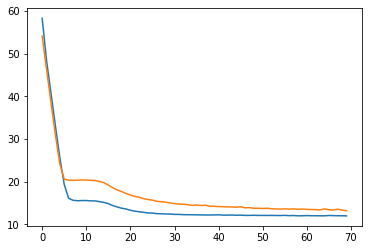

In [21]:
history=model.history.history
plt.plot([i for i in range(len(history['loss']))],history['loss'])
plt.plot([i for i in range(len(history['val_loss']))],history['val_loss'])

### Generating music

In [22]:
def tune_generator(model, name='lstm_tune_'):
    for i in range(3):
        start = np.random.randint(0, len(X)-1)
        pattern = X[start]
        prediction_output = []

        for note_index in range(100):
            prediction_input = np.reshape(pattern, (1, len(pattern), 3))
            prediction = model.predict(prediction_input, verbose=0)
            prediction_output.append(prediction.astype(int)[0])
            pattern = np.append(pattern, prediction, axis = 0)
            pattern = pattern[1:len(pattern)]

        notes = pd.DataFrame(prediction_output, columns=['time', 'note', 'velocity'])
        notes['pause'] = 180
        notes_dict = notes.to_dict('records')
        tune_to_midi(notes_dict, midi_name=name + str(i))

In [23]:
tune_generator(model, name='lstm_mod_')

## LSTM using embedding

In [24]:
n_notes = 128
embed_size = 100

In [25]:
notes_in = Input(shape = (phrase_len,))
durations_in = Input(shape = (phrase_len,1))

notes_embed = Embedding(n_notes, embed_size)(notes_in)

concat_model = Concatenate()([notes_embed,durations_in])
concat_model = Dropout(0.3)(concat_model)
concat_model = LSTM(512, return_sequences=False)(concat_model)

notes_out = Dense(n_notes, activation = 'softmax', name = 'note')(concat_model)
durations_out = Dense(1, activation = 'relu', name = 'duration')(concat_model)

embed_model = Model([notes_in, durations_in], [notes_out, durations_out])
embed_model.compile(loss=['sparse_categorical_crossentropy', 
                    'mse'], optimizer=RMSprop(lr = 0.001))

In [26]:
train_chords = X[:, :, 1]
train_durations = X[:, :, 0]
target_chords = y[:, 1]
target_durations = y[:, 0]

embed_model.fit([train_chords, train_durations], 
                    [target_chords, target_durations]
                    , epochs=200, batch_size=256, validation_split=0.2
                  )

Epoch 1/200
23/23 [==============================] - 3s 55ms/step - loss: 21184.0598 - note_loss: 4.0149 - duration_loss: 21180.0461 - val_loss: 77909.6641 - val_note_loss: 3.8331 - val_duration_loss: 77905.8281
Epoch 2/200
23/23 [==============================] - 1s 36ms/step - loss: 23893.3925 - note_loss: 3.6279 - duration_loss: 23889.7637 - val_loss: 77953.7891 - val_note_loss: 3.7321 - val_duration_loss: 77950.0625
Epoch 3/200
23/23 [==============================] - 1s 36ms/step - loss: 31297.4918 - note_loss: 3.5916 - duration_loss: 31293.9000 - val_loss: 77969.0938 - val_note_loss: 3.7022 - val_duration_loss: 77965.3906
Epoch 4/200
23/23 [==============================] - 1s 36ms/step - loss: 23443.1535 - note_loss: 3.6063 - duration_loss: 23439.5489 - val_loss: 78031.1016 - val_note_loss: 3.7192 - val_duration_loss: 78027.3828
Epoch 5/200
23/23 [==============================] - 1s 36ms/step - loss: 23058.6899 - note_loss: 3.5978 - duration_loss: 23055.0916 - val_loss: 78288.3

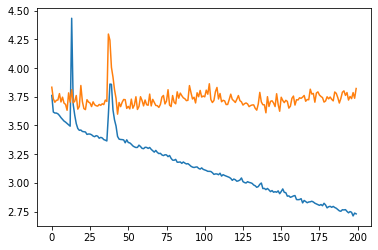

In [27]:
history=embed_model.history.history
plt.plot([i for i in range(len(history['note_loss']))],history['note_loss'])
plt.plot([i for i in range(len(history['val_note_loss']))],history['val_note_loss'])

In [28]:
for i in range(3):
    start = np.random.randint(0, len(X)-1)
    pattern_chords = X[start, :, 1]
    pattern_durations = X[start, :, 0]

    prediction_output = []
    
    for note_index in range(100):
        pattern_chords = np.reshape(pattern_chords, (1, len(pattern_chords), 1))
        pattern_durations = np.reshape(pattern_durations, (1, len(pattern_durations), 1))

        prediction = embed_model.predict([pattern_chords, pattern_durations], verbose=0)
        index = np.random.choice(n_notes, p=prediction[0][0])
        duration = prediction[1][0][0]

        prediction_output.append([index, int(duration)])

        pattern_chords = np.append(pattern_chords, index)
        pattern_chords = pattern_chords[1:len(pattern_chords)]

        pattern_durations = np.append(pattern_durations, duration)
        pattern_durations = pattern_durations[1:len(pattern_durations)]

    notes = pd.DataFrame(prediction_output, columns=['note', 'time'])
    notes['pause'] = 180
    notes['velocity'] = 80
    notes_dict = notes.to_dict('records')
    tune_to_midi(notes_dict, midi_name='embed_lstm_' + str(i))

## GAN

Let's treat our music data as a picture, where width is time length and height is number of notes. We will mark a "pixel" if the note is played at the time of this "pixel".

In [29]:
u, c = np.unique(X[:, :, 0].sum(axis=1), return_counts=True)
np.median(u)

2150.0

In [30]:
def tune_to_matrix(tune, tune_len=4000):
    notes_matrix = np.zeros((128, tune_len))
    i = 0
    for n in tune:
        for j in range(int(n[0] / 4)):
            notes_matrix[n[1], i] = 1
            i += 1
            if i == tune_len:
                break
        if i == tune_len:
            break
    return notes_matrix

In [31]:
X[0, :, 0].sum()

432

In [32]:
tune_to_matrix(X[0]).sum(axis=1)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  1., 58.,  0.,
        5.,  0.,  4.,  9.,  0.,  7.,  2.,  4.,  0.,  0.,  4.,  0.,  0.,
        0.,  0.,  4.,  0.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [33]:
tune_len = 200
n_notes = 128

train_matrixes = []
for x in X[:1000]:
    train_matrixes.append(tune_to_matrix(x, tune_len=200))

In [34]:
len(train_matrixes)

1000

### Fitting the model

In [35]:
latent_dim = 64

In [36]:
discriminator = Sequential(
    [
        Input((n_notes, tune_len)),
        Reshape((n_notes, tune_len, 1)),
        Conv2D(4, (8, 4), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(8, (8, 4), padding="same"),
        LeakyReLU(alpha=0.2),
        GlobalMaxPooling2D(),
        Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)

In [37]:
# Create the generator.
generator = Sequential(
    [
        Input((latent_dim,)),
        Dense(n_notes * tune_len * latent_dim),
        Reshape((n_notes, tune_len, latent_dim)),
        Conv2DTranspose(1, (4, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, (4, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(1, (6, 4)),
        Flatten(),
        Dense(n_notes * tune_len, activation='sigmoid'),
        Reshape((n_notes, tune_len)),
    ],
    name="generator",
)

In [38]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1638400)           106496000 
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 200, 64)      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 200, 1)       513       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 200, 1)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 200, 1)       9         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 200, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 197, 1)       25

In [39]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.distr = tf.random.uniform

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, real_tunes):
        # Sample random points in the latent space 
        # This is for the generator.
        batch_size = tf.shape(real_tunes)[0]
        random_latent_vectors = self.distr(shape=(batch_size, self.latent_dim))


        # Decode the noise (guided by labels) to fake images.
        generated_tunes= self.generator(random_latent_vectors)
        
        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions_real = self.discriminator(real_tunes)
            predictions_fake = self.discriminator(generated_tunes)
            d_loss = self.d_loss_fn([predictions_fake, predictions_real], [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))])
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = self.distr(shape=(batch_size, self.latent_dim))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_tunes = self.generator(random_latent_vectors)
            predictions = self.discriminator(fake_tunes)
            g_loss = self.g_loss_fn(predictions, tf.zeros((batch_size, 1)))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [40]:
dataset = np.array(train_matrixes[:256])

I tried to prevent mode collapse, but failed(

In [41]:
def discriminator_loss(pred, labels):
    real_loss = tf.reduce_mean(pred[1])
    fake_loss = tf.reduce_mean(pred[0])
    return real_loss - 2 * fake_loss


def generator_loss(pred, labels):
    return tf.reduce_mean(pred)

In [42]:
gan = GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.000005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

gan.fit(dataset, epochs=60)

Epoch 1/60
8/8 [==============================] - 2s 121ms/step - g_loss: 0.5567 - d_loss: -0.4808
Epoch 2/60
8/8 [==============================] - 1s 122ms/step - g_loss: 0.5530 - d_loss: -0.4728
Epoch 3/60
8/8 [==============================] - 1s 121ms/step - g_loss: 0.5498 - d_loss: -0.4665
Epoch 4/60
8/8 [==============================] - 1s 120ms/step - g_loss: 0.5468 - d_loss: -0.4604
Epoch 5/60
8/8 [==============================] - 1s 120ms/step - g_loss: 0.5444 - d_loss: -0.4561
Epoch 6/60
8/8 [==============================] - 1s 120ms/step - g_loss: 0.5421 - d_loss: -0.4519
Epoch 7/60
8/8 [==============================] - 1s 119ms/step - g_loss: 0.5398 - d_loss: -0.4470
Epoch 8/60
8/8 [==============================] - 1s 120ms/step - g_loss: 0.5375 - d_loss: -0.4428
Epoch 9/60
8/8 [==============================] - 1s 120ms/step - g_loss: 0.5348 - d_loss: -0.4381
Epoch 10/60
8/8 [==============================] - 1s 123ms/step - g_loss: 0.5321 - d_loss: -0.4323
Epoch 11/

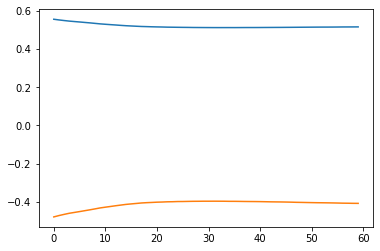

In [43]:
history=gan.history.history
plt.plot([i for i in range(len(history['g_loss']))],history['g_loss'])

plt.plot([i for i in range(len(history['d_loss']))],history['d_loss'])

In [44]:
def extract_tune(matrix):
    time = 0
    note = -1
    tune = []
    for i in range(matrix.shape[1]):
        new_note = np.argmax(matrix[:, i])
        if note != new_note:
            if note != -1:
                tune.append([time, note])
            note = new_note
            time = 4
        else:
            time += 4
    tune.append([time, note])
    return tune

In [45]:
for i in range(3):
    random_latent_vectors = tf.random.uniform(shape=(1, latent_dim))
    tunes = gan.generator(random_latent_vectors)
    t = extract_tune(tunes[0])
    notes = pd.DataFrame(t, columns=['time', 'note'])
    notes['pause'] = 180
    notes['velocity'] = 80
    notes_dict = notes.to_dict('records')
    tune_to_midi(notes_dict, midi_name='gan_mod_' + str(i))

## Conclusion

I think, plain LSTM wasn't complex enough and CNN as it is used here is not really suitable for this type of task. LSTM with embedding was the best.

In [46]:
from music21 import midi

def play_midi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

In [47]:
play_midi('./lstm_mod_0.mid')

In [48]:
play_midi('./embed_lstm_0.mid')

In [49]:
play_midi('./gan_mod_0.mid')